# TEST Elevated Plus Maze (EPM) Analysis

In [1]:
from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import SigProc
import sys

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
sns.set_style("darkgrid")

In [4]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/EPM")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: behavior_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv
1. full path of: Raw_EPM_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv
2. full path of: Raw_EPM_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv
3. full path of: behavior_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv
4. full path of: Raw_EPM_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/Raw_EPM_drd77.csv
5. full path of: behavior_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv
6. full path of: behavior_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv
7. full path of: Raw_EPM_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv


In [5]:
data = pd.read_csv(raw_files[1], header=None)
_, auc_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

In [6]:
beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

behavior_df = pd.read_csv(raw_files[0], header=None)
drd87_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=behavior_df, behavior_col_names=beh_cols)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [7]:
drd87_fe.neuron_line_plot("neuron38", "neuron45", dataframe=drd87_fe.neuron_concated_behavior)

In [8]:
drd87_fe.compute_diff_rate(drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:103: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



array([-4.19561264,  6.95370325,  5.8623402 , 12.29110312,  7.69429526,
       -1.02770174,  1.02404516, -0.86089406, -3.20938391,  2.44694614,
       -3.72822216,  1.12666774,  4.56576493, -1.3459389 ,  9.08028438,
        8.2947741 ,  2.90390003, -3.66245997, -0.72146725, -1.29776907,
        0.70960371,  3.37547092,  1.86487746,  0.25161911, 10.38870066,
        5.79680887,  2.61224175,  2.66464028,  2.67196213, -1.19520223,
       15.30874198,  4.92833305, -3.69805129, 12.73370276, -0.23153988,
        1.02891031, -2.70805314, -3.0826746 ,  0.8078336 ,  1.96816951,
       -1.14905654,  0.59838722,  2.21717533, -1.2518552 , -2.42448633,
        2.54065298,  6.29254069, -0.54548862,  9.40527757, 10.16086774,
       -1.94102076,  0.01818844,  1.02971022, 13.3724591 ,  9.37019765,
        2.68220031,  5.57973281, -4.06557519,  4.84070485,  9.97404996,
       -1.61009934,  6.50104439,  0.43431744,  5.00546957,  9.15386108,
        5.86695994,  0.97380921, -1.97103871, 13.03695956])

In [9]:
real_diff_vals = drd87_fe.set_real_diff_df(drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:103: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron60,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69
D,-4.19561,6.9537,5.86234,12.2911,7.6943,-1.0277,1.02405,-0.860894,-3.20938,2.44695,...,9.97405,-1.6101,6.50104,0.434317,5.00547,9.15386,5.86696,0.973809,-1.97104,13.037


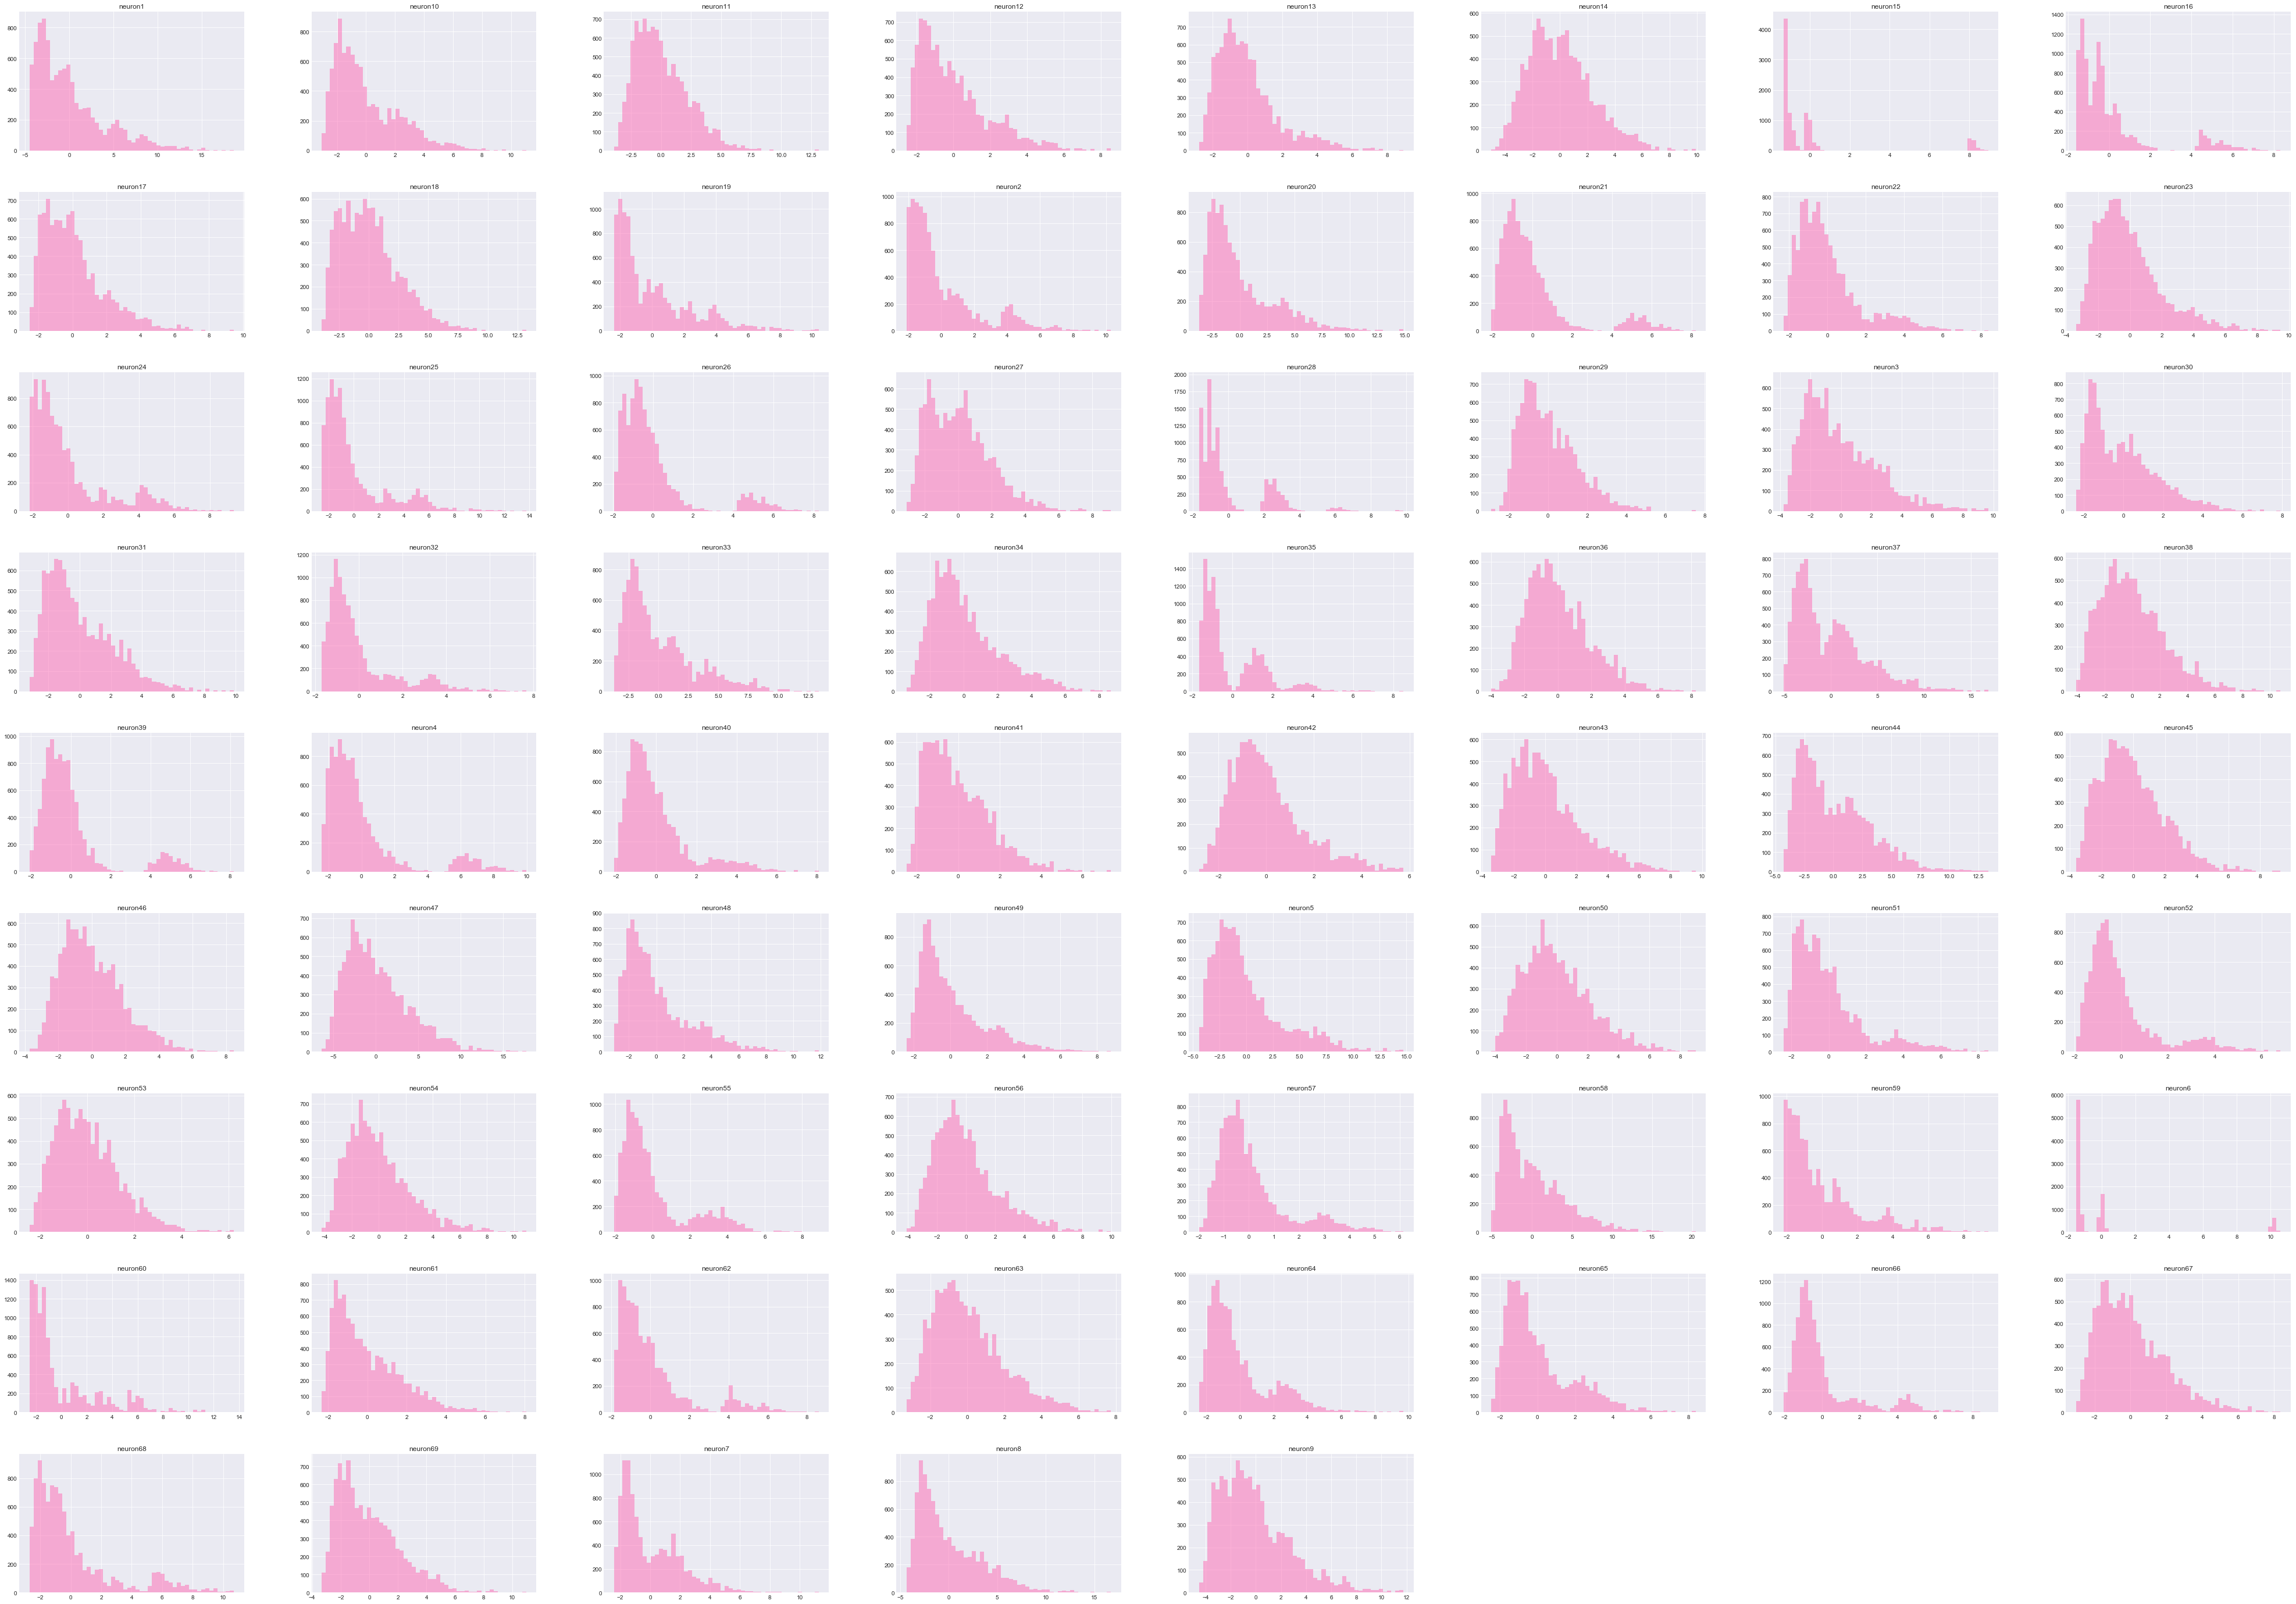

In [10]:
drd87_resampled_df = Resampler.shuffle(10000, drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
drd87_resampled_df.hist(alpha=0.5, color='hotpink', bins=50, figsize=(70, 50));

In [11]:
classified_neurons = Resampler.non_normal_neuron_classifier(drd87_fe.auc_df, drd87_resampled_df, real_diff_vals, p_value=0.125, threshold=10)

In [12]:
def classify_for_behavior(classified_neurons, real_diff_vals): 
    deeper_classification = classified_neurons.copy()

    for neuron in deeper_classification:
        if real_diff_vals[neuron].values > 0:
            if deeper_classification[neuron] == "selective":
                deeper_classification[neuron] = "OpenArms_centerpoint"
        elif real_diff_vals[neuron].values < 0:
            if deeper_classification[neuron] == "selective":
                deeper_classification[neuron] = "ClosedArms_centerpoint"
                
    return deeper_classification

In [13]:
drd87_neurons_dict = classify_for_behavior(classified_neurons, real_diff_vals)

In [14]:
import plotly
import plotly.graph_objs as go

def plot_pie_chart(dict_of_classifications, *labels):
    values = [sum([1 for classification in dict_of_classifications.values() if classification == "OpenArms_centerpoint"])]
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == "ClosedArms_centerpoint"]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == "not-selective"]))
    values.append(sum([1 for classification in dict_of_classifications.values() if classification == "unclassified"]))
    
    trace = go.Pie(labels=labels, values=values)
    plotly.offline.iplot([trace])

In [15]:
plot_pie_chart(drd87_neurons_dict, "OpenArms_centerpoint", "ClosedArms_centerpoint", "not-selective", "unclassified")

In [16]:
# Only if distributions are normal.
# normal_classification = Resampler.normal_neuron_classifier(drd87_fe.auc_df, drd87_resampled_df, real_diff_vals, behavior1_name="OpenArms_centerpoint", behavior2_name="ClosedArms_centerpoint", high=87.5, low=12.5, threshold=5)

In [17]:
def activity_by_neurons(concated_df, neuron_names, *behaviors, frame_rate=10):
    """Computes the neuron activity rates for given behaviors
    
    This function computes the rates for a given animal's activity and  
    neuron, given some set of behaviors.

    Args: 
        concated_df: a concatenated pandas DataFrame of the neuron activity and 
        the corresponding behavior, for a given animal.
        neuron_names: the names of the neurons whose rates are to be computed.
        behaviors: a list of the behaviors for which to compute the activity rates. 
        frame_rate: the framerate to multiply the rate by, default is 10.

    Returns: 
        activity_df: a pandas DataFrame of the neuron activity rates.
    """
    activity_df = pd.DataFrame(columns=behaviors)
    
    for behavior in behaviors:
        if behavior in concated_df.columns:
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[concated_df[behavior] != 0, neuron_names].mean()
        elif '&' in behavior:
            beh1 = behavior.split('&')[0]
            beh2 = behavior.split('&')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) & ((concated_df[beh2] != 0)), neuron_names].mean()
        elif '|' in behavior:
            beh1 = behavior.split('|')[0]
            beh2 = behavior.split('|')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) | ((concated_df[beh2] != 0)), neuron_names].mean()

    return activity_df

In [18]:
activity_rates_df = activity_by_neurons(drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "ClosedArms_centerpoint", "OpenArms_centerpoint")

# Plot scatterplot of neurons, where $x$-axis is the closedarms rate, $y$-axis is the openarms rate, and the entire scatterplot is bisected by the line $y=x$

In [19]:
open_arms_plot_dict = dict()
closed_arms_plot_dict = dict()
unclassified_plot_dict = dict()
not_selective_plot_dict = dict()

for neuron in drd87_neurons_dict:
    if drd87_neurons_dict[neuron] == "OpenArms_centerpoint":
        if neuron not in open_arms_plot_dict:
            open_arms = activity_rates_df.loc[neuron, "OpenArms_centerpoint"]
            closed_arms = activity_rates_df.loc[neuron, "ClosedArms_centerpoint"]
            open_arms_plot_dict[neuron] = {"OpenArms_centerpoint": open_arms, "ClosedArms_centerpoint": closed_arms}
    
    elif drd87_neurons_dict[neuron] == "ClosedArms_centerpoint":
        if neuron not in closed_arms_plot_dict:
            open_arms = activity_rates_df.loc[neuron, "OpenArms_centerpoint"]
            closed_arms = activity_rates_df.loc[neuron, "ClosedArms_centerpoint"]
            closed_arms_plot_dict[neuron] = {"OpenArms_centerpoint": open_arms, "ClosedArms_centerpoint": closed_arms}
    
    elif drd87_neurons_dict[neuron] == "unclassified":
        if neuron not in unclassified_plot_dict:
            open_arms = activity_rates_df.loc[neuron, "OpenArms_centerpoint"]
            closed_arms = activity_rates_df.loc[neuron, "ClosedArms_centerpoint"]
            unclassified_plot_dict[neuron] = {"OpenArms_centerpoint": open_arms, "ClosedArms_centerpoint": closed_arms}
            
    elif drd87_neurons_dict[neuron] == "not-selective":
        if neuron not in not_selective_plot_dict:
            open_arms = activity_rates_df.loc[neuron, "OpenArms_centerpoint"]
            closed_arms = activity_rates_df.loc[neuron, "ClosedArms_centerpoint"]
            not_selective_plot_dict[neuron] = {"OpenArms_centerpoint": open_arms, "ClosedArms_centerpoint": closed_arms}

In [20]:
def get_scatter_points(neurons_plot_dict):
    x_axis = list()
    y_axis = list()
    
    for neuron in neurons_plot_dict:
        x_axis.append(neurons_plot_dict[neuron]["OpenArms_centerpoint"])
        y_axis.append(neurons_plot_dict[neuron]["ClosedArms_centerpoint"])
        
    return x_axis, y_axis

In [21]:
# Create traces

# Plot y=x line
trace0 = go.Scatter(
    x = np.linspace(0, max(activity_rates_df["OpenArms_centerpoint"].max(), activity_rates_df["ClosedArms_centerpoint"].max())),
    y = np.linspace(0, max(activity_rates_df["OpenArms_centerpoint"].max(), activity_rates_df["ClosedArms_centerpoint"].max())),
    mode = "lines",
    name = "y=x",
    marker = dict(
        color = "rgb(0, 0, 0)"
    )
)

x_axis, y_axis = get_scatter_points(open_arms_plot_dict)

# Plot OpenArms selective neurons
trace1 = go.Scatter(
    x = x_axis,
    y = y_axis,
    text = [neuron for neuron in drd87_neurons_dict if drd87_neurons_dict[neuron] == "OpenArms_centerpoint"],
    mode = "markers",
    name = "OpenArms",
    marker = dict(
        color = "rgb(255, 10, 193)"
    )
)

x_axis, y_axis = get_scatter_points(closed_arms_plot_dict)

# Plot ClosedArms selective neurons
trace2 = go.Scatter(
    x = x_axis,
    y = y_axis,
    text = [neuron for neuron in drd87_neurons_dict if drd87_neurons_dict[neuron] == "ClosedArms_centerpoint"],
    mode = "markers",
    name = "ClosedArms",
    marker = dict(
        color = 'rgb(105, 105, 255)'
    )
)

x_axis, y_axis = get_scatter_points(unclassified_plot_dict)
    
# Plot unclassified neurons
trace3 = go.Scatter(
    x = x_axis,
    y = y_axis,
    text = [neuron for neuron in drd87_neurons_dict if drd87_neurons_dict[neuron] == "unclassified"],
    mode = "markers",
    name = "unclassified",
    marker = dict(
        color = "rgb(150, 150, 150)"
    )
)

x_axis, y_axis = get_scatter_points(not_selective_plot_dict)

# Plot not-selective neurons
trace4 = go.Scatter(
    x = x_axis,
    y = y_axis,
    text = [neuron for neuron in drd87_neurons_dict if drd87_neurons_dict[neuron] == "not-selective"],
    mode = "markers",
    name = "not-selective",
    marker = dict(
        color = "rgb(0, 200, 0)"
    )
)

data = [trace0, trace1, trace2, trace3, trace4]
layout = go.Layout(
    width=800,
    height=800,
    title="Open-arms neuron rates vs Closed-arms neuron rates",
)
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)